# Diffprivlib Experiment: Random Forest
---
<b>Author: A.Krauskopf<b><br>
<b>Last Update: 29 Oct 2024<b>

This notebook includes the iterative experiment code and figure creation focusing on both non-differentially private and differentially private instances of the random forest ensemble method. It depends upon the .csv files referenced to reside in the datasets subfolder in the same directory as this notebook. It also requires a figures subfolder for the resulting imagery to be saved to.

<b>Package Prerequisites:<b>
- pandas
- numpy
- matplotlib
- joblib
- tqdm
- sklearn
- diffprivlib

<b>Other Notebooks:<b>
- Gaussian Naiive Bayes (Diffprivlib Experiment-NB.ipynb)
- Logistic Regression (Diffprivlib Experiment-LR.ipynb)<br>

### 1: Setup

In [54]:
# Import necessary packages
from tqdm import tqdm
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import matthews_corrcoef
from sklearn.ensemble import ExtraTreesClassifier
import diffprivlib as dp
from joblib import Parallel, delayed
import time

In [55]:
# Setup dataframe to hold timing statistics
rf_runtime = pd.DataFrame(columns=['Setup', 'Validate', 'Baseline', 'Compare'], index=['Start Time', 'End Time', 'Runtime'])

# Capture start time
rf_runtime.loc['Start Time', 'Setup'] = time.time()

In [56]:
# Open and read the data into a dataframe
train = pd.read_csv('../datasets/fraudTrain_clean.csv', index_col=0)
test = pd.read_csv('../datasets/fraudTest_clean.csv', index_col=0)

# Split into dependent and independent variables
X_train = train.drop(['is_fraud'], axis=1)
y_train = train['is_fraud']

X_test = test.drop(['is_fraud'], axis=1)
y_test = test['is_fraud']

X_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1296675 entries, 0 to 1296674
Data columns (total 13 columns):
 #   Column          Non-Null Count    Dtype  
---  ------          --------------    -----  
 0   user            1296675 non-null  int64  
 1   category        1296675 non-null  int64  
 2   amt             1296675 non-null  float64
 3   state           1296675 non-null  int64  
 4   zip             1296675 non-null  int64  
 5   city_pop        1296675 non-null  int64  
 6   job             1296675 non-null  int64  
 7   age             1296675 non-null  int64  
 8   day_of_week     1296675 non-null  int64  
 9   hour            1296675 non-null  int64  
 10  userpref_day    1296675 non-null  int64  
 11  userpref_time   1296675 non-null  int64  
 12  userpref_spend  1296675 non-null  float64
dtypes: float64(2), int64(11)
memory usage: 138.5 MB


In [57]:
# Additional requirements specific to DP-RF

# Calculate the bounds
total = pd.concat([train, test], ignore_index=True, sort=False)
min_values = total.min().tolist()[:-1]
max_values = total.max().tolist()[:-1]
bounds = (min_values, max_values)

# Calculate the classes to prevent a privacy warning with DP-RF
classes = np.array([0, 1],)
#I get an average of 0.49 when the system calcs the classes so this is correct

rf_runtime.loc['End Time', 'Setup'] = time.time()

### 2: Verify DP(ε =∞) = non-private scikit learn

In [58]:
rf_runtime.loc['Start Time', 'Validate'] = time.time()

# Compare the baseline non-DP to DP @ infinity value
num_runs = 30
rf_noDP_mcc_list = []
rf_DP_mcc_list = []

for run in tqdm(range(num_runs)):
    rf_noDP = ExtraTreesClassifier(bootstrap=True, 
                                   n_estimators=10,
                                   random_state=(42 + run), 
                                   max_depth=15)
    rf_noDP.fit(X_train, y_train)
    y_pred_rf_noDP = rf_noDP.predict(X_test)
    rf_noDP_mcc_list.append(matthews_corrcoef(y_test, y_pred_rf_noDP))

    rf_DP = dp.models.RandomForestClassifier(epsilon=np.inf, 
                                      random_state=(42 + run), 
                                      bounds=bounds, 
                                      classes=classes,
                                      n_estimators=10,
                                      max_depth=15)
    rf_DP.fit(X_train, y_train)
    y_pred_rf_DP = rf_DP.predict(X_test)
    rf_DP_mcc_list.append(matthews_corrcoef(y_test, y_pred_rf_DP))

# Convert list to numpy arrays
rf_noDP_mcc_list = np.array(rf_noDP_mcc_list)
rf_DP_mcc_list = np.array(rf_DP_mcc_list)

print("noDP MCC: ", rf_noDP_mcc_list.mean()) # 0.998
print("DP(e=inf) MCC: ", rf_DP_mcc_list.mean()) # 0.4936

rf_runtime.loc['End Time', 'Validate'] = time.time()

100%|█████████████████████████████████████| 30/30 [13:13<00:00, 26.46s/it]

noDP MCC:  0.9981720127206825
DP(e=inf) MCC:  0.49216114940283195


### 3: Baseline DP

In [59]:
rf_runtime.loc['Start Time', 'Baseline'] = time.time()

# Define the method to train a DP version of RF

def train_DPrf(run, epsilon, X_train, X_test, y_train, y_test):
    DPrf = dp.models.RandomForestClassifier(epsilon=epsilon, random_state=(42 + run), 
                                            bounds=bounds, classes=classes, 
                                            max_depth=15, n_estimators=10)
    DPrf.fit(X_train, y_train)
    y_pred_DPrf = DPrf.predict(X_test)
    return {
        "epsilon": epsilon,
        "run": run,
        "mcc": matthews_corrcoef(y_test, y_pred_DPrf),
    }

Important (!): The pipelined version of the train_DPrf method requires that the parameters X_train, X_test, y_train, and y_test be supplied as writeable numpy arrays by adding .values to the dataframes to ensure thread safety. The non-pipelined version does not require this step.

In [60]:
# Define the data for the first graph using parallel processing

# Define the range of epsilon values including infinity
epsilons = np.logspace(-3, 1, 50)
epsilons = np.append(epsilons, np.inf)
num_runs = 30

# Prepare a list of tasks
tasks = [(run, epsilon) for run in range(num_runs) for epsilon in epsilons]

# Convert dataframes to writeable numpy arrays for pipelining
X_train_np = X_train.values
X_test_np = X_test.values
y_train_np = y_train.values
y_test_np = y_test.values

# Run tasks with parallel processing and tqdm for progress monitoring
results = Parallel(n_jobs=-1, backend="loky")(
    delayed(train_DPrf)(run, epsilon, X_train_np, X_test_np, y_train_np, y_test_np) 
    for run, epsilon in tqdm(tasks, desc="Processing", total=len(tasks))
)

# Convert data to dataframe and average across all runs
DPrf_mcc_df = pd.DataFrame(results).set_index("epsilon")
grouped_mcc = DPrf_mcc_df.groupby("epsilon")["mcc"].mean()

# Separate the non-private MCC values (epsilon = infinity)
avg_rf_noDP_mcc = grouped_mcc[np.inf]
avg_DPrf_mcc = grouped_mcc.iloc[:-1]

print(avg_DPrf_mcc)
rf_runtime.loc['End Time', 'Baseline'] = time.time()

Processing: 100%|███████████████████| 1530/1530 [1:12:46<00:00,  2.85s/it]


epsilon
0.001000     0.100855
0.001207     0.110268
0.001456     0.122757
0.001758     0.131520
0.002121     0.140945
0.002560     0.157345
0.003089     0.189283
0.003728     0.189913
0.004498     0.219509
0.005429     0.238793
0.006551     0.249209
0.007906     0.256906
0.009541     0.273412
0.011514     0.280934
0.013895     0.300816
0.016768     0.320416
0.020236     0.326734
0.024421     0.320413
0.029471     0.329122
0.035565     0.336851
0.042919     0.345105
0.051795     0.350413
0.062506     0.370753
0.075431     0.376889
0.091030     0.384905
0.109854     0.398200
0.132571     0.414098
0.159986     0.417896
0.193070     0.428602
0.232995     0.430320
0.281177     0.443890
0.339322     0.447993
0.409492     0.461336
0.494171     0.459451
0.596362     0.466056
0.719686     0.478951
0.868511     0.477878
1.048113     0.484328
1.264855     0.482509
1.526418     0.486219
1.842070     0.488205
2.222996     0.487619
2.682696     0.489107
3.237458     0.493841
3.906940     0.491246
4.

In [61]:
#Output min and max from the baseline data

# Get the minimum and maximum epsilon values (index)
epsilon_min = avg_DPrf_mcc.index.min()
epsilon_max = avg_DPrf_mcc.index.max()

# Get the minimum and maximum MCC values (values of the Series)
mcc_min = avg_DPrf_mcc.min()
mcc_max = avg_DPrf_mcc.max()

# Output the results
print("Minimum epsilon:", epsilon_min)
print("Maximum epsilon:", epsilon_max)
print("Minimum MCC:", mcc_min)
print("Maximum MCC:", mcc_max)

epsilon
0.001000     0.100855
0.001207     0.110268
0.001456     0.122757
0.001758     0.131520
0.002121     0.140945
0.002560     0.157345
0.003089     0.189283
0.003728     0.189913
0.004498     0.219509
0.005429     0.238793
0.006551     0.249209
0.007906     0.256906
0.009541     0.273412
0.011514     0.280934
0.013895     0.300816
0.016768     0.320416
0.020236     0.326734
0.024421     0.320413
0.029471     0.329122
0.035565     0.336851
0.042919     0.345105
0.051795     0.350413
0.062506     0.370753
0.075431     0.376889
0.091030     0.384905
0.109854     0.398200
0.132571     0.414098
0.159986     0.417896
0.193070     0.428602
0.232995     0.430320
0.281177     0.443890
0.339322     0.447993
0.409492     0.461336
0.494171     0.459451
0.596362     0.466056
0.719686     0.478951
0.868511     0.477878
1.048113     0.484328
1.264855     0.482509
1.526418     0.486219
1.842070     0.488205
2.222996     0.487619
2.682696     0.489107
3.237458     0.493841
3.906940     0.491246
4.

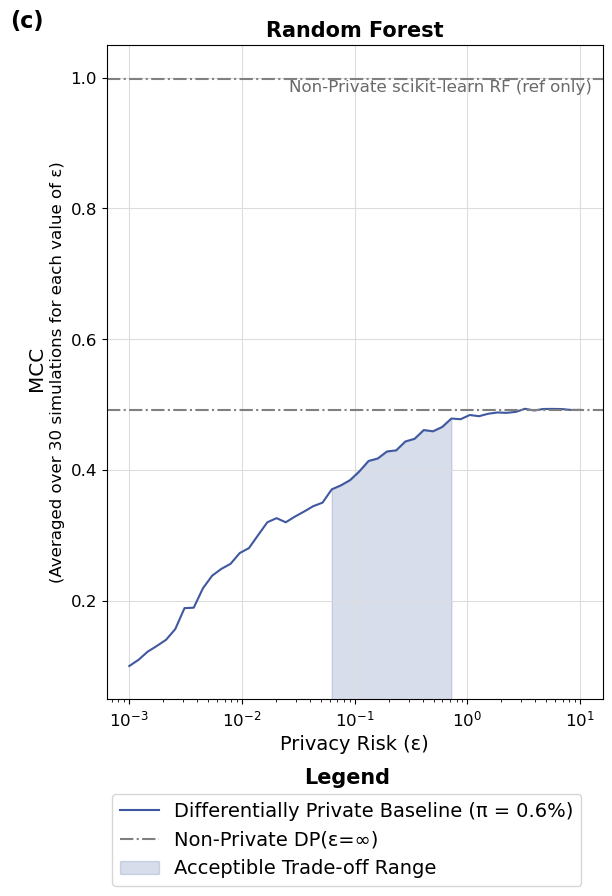

In [99]:
# Plot a tall version of the first graph

# Create the figure with the specified size
fig_rf1 = plt.figure(figsize=(6.4, 8.5))

# Plot the main line
plt.semilogx(epsilons[:-1], avg_DPrf_mcc, color='#40589F', label="Differentially Private Baseline (π = 0.6%)")

# Use list comprehension to plot multiple horizontal lines
[plt.axhline(y=y, color=color, linestyle=style, label=label) for y, color, style, label in zip(
    [rf_noDP_mcc_list.mean(), rf_DP_mcc_list.mean()],
    ['grey', 'grey'],
    ['-.', '-.'],
    ["", "Non-Private DP(ε=∞)"])
]

# Define the bounds for x values
x_lower, x_upper = 0.051795, 0.719686

# Find the indices where epsilons fall within the specified x range
x_mask = (epsilons[:-1] >= x_lower) & (epsilons[:-1] <= x_upper)

# Fill the area under the curve between 0 and the curve values
plt.fill_between(epsilons[:-1][x_mask], 0, avg_DPrf_mcc[x_mask], 
                 where=(avg_DPrf_mcc[x_mask] >= 0), 
                 color='#40589F', alpha=0.2, label="Acceptible Trade-off Range")

plt.title("Random Forest", fontweight='bold', fontsize=15)
plt.grid(which='major', color='#DDDDDD', linewidth=0.8)
plt.xlabel("Privacy Risk (ε)", fontsize=14)
plt.ylabel("(Averaged over 30 simulations for each value of ε)", fontsize=12)
fig_rf1.figure.supylabel("MCC", fontsize="x-large", x=0)

# Set font size for tick labels
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

# Set y-axis limits
plt.ylim(0.05, 1.05)  # Set limits to prevent stretching

# Add the legend below the plot
handles, labels = plt.gca().get_legend_handles_labels()
legend = fig_rf1.legend(handles, labels, loc='upper center', ncol=1, bbox_to_anchor=(0.5, .01), fontsize=14)

# Add a separate text elements
plt.figtext(0.5, .01, "Legend", ha="center", fontsize=plt.gca().title.get_fontsize(), fontweight='bold')
plt.figtext(0, 0.9, "(c)", ha="center", fontsize=16, fontweight='bold')
plt.figtext(0.41, 0.825, 'Non-Private scikit-learn RF (ref only)', horizontalalignment='left', wrap=True, color='dimgray', fontsize=12)

# Save and show the plot
plt.savefig('../figures/RF-Graph4.png', dpi=600, bbox_inches='tight') 
plt.show()

### 4: Exploring the impact of imbalance

In [63]:
rf_runtime.loc['Start Time', 'Compare'] = time.time()

# Define the data for the second graph using parallel processing

# Define data files and parameters
sampledTrain = ['fraudTrain_1%.csv', 'fraudTrain_2%.csv', 'fraudTrain_3%.csv', 
              'fraudTrain_4%.csv', 'fraudTrain_5%.csv', 'fraudTrain_10%.csv',
               'fraudTrain_15%.csv', 'fraudTrain_20%.csv']
colNames = ['1%', '2%', '3%', '4%', '5%', '10%', '15%', '20%']

epsilons = np.logspace(-3, 1, 50)
epsilons = np.append(epsilons, np.inf)
num_runs = 30

# Dictionaries to store the resulting dataframes
avg_DPrf_sampled_mcc_dict = {}
avg_rf_noDP_sampled_mcc_dict = {}

# Prepare a list of tasks
tasks_sampled = [(run, epsilon) for run in range(num_runs) for epsilon in epsilons]

# Loop through the training and test files
for file, name in zip(sampledTrain, colNames):
    # Load the datasets
    sampled_data = pd.read_csv(f'../datasets/{file}')
    X_train_sampled = sampled_data.drop(['is_fraud'], axis=1)
    y_train_sampled = sampled_data['is_fraud']

    # Convert dataframes to writeable numpy arrays for pipelining
    X_train_sampled = X_train_sampled.values
    y_train_sampled = y_train_sampled.values
    
    # Empty list for the loop to fill
    dprf_mcc_sampled_rows = []

    # Use joblib to parallelize the loop
    results_sampled = Parallel(n_jobs=-1)(
        delayed(train_DPrf)(run, epsilon, X_train_sampled, X_test_np, y_train_sampled, y_test_np)
        for run, epsilon in tqdm(tasks_sampled, desc="Processing", total=len(tasks_sampled))
    )

    # Convert data to dataframe
    dprf_mcc_sampled_df = pd.DataFrame(results_sampled)

    # Compute the average MCC across all runs
    grouped_mcc_sampled = dprf_mcc_sampled_df.groupby("epsilon")["mcc"].mean()

    # Separate the non-private MCC value (epsilon = infinity)
    avg_rf_noDP_sampled_mcc = grouped_mcc_sampled[np.inf]
    avg_DPrf_sampled_mcc = grouped_mcc_sampled.iloc[:-1]

    # Store the resulting dataframe in the dictionary
    avg_rf_noDP_sampled_mcc_dict[name] = avg_rf_noDP_sampled_mcc
    avg_DPrf_sampled_mcc_dict[name] = avg_DPrf_sampled_mcc

# Access the resulting dataframes using avg_DPrf_mcc_dict
print('Complete')

Processing:  44%|█████████▋            | 670/1530 [31:46<41:57,  2.93s/it]/Users/firefly/anaconda3/envs/IRP/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
Processing:   1%|▎                      | 20/1530 [00:29<36:51,  1.46s/it]/Users/firefly/anaconda3/envs/IRP/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
Processing:   1%|▎                      | 20/1530 [00:29<36:59,  1.47s/it]/Users/firefly/anaconda3/envs/IRP/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or 

Complete


In [64]:
# Add previously calculated baseline runs to the dictionaries
avg_rf_noDP_sampled_mcc_dict['Baseline'] = avg_rf_noDP_mcc.mean()
avg_DPrf_sampled_mcc_dict['Baseline'] = avg_DPrf_mcc

#print(avg_rf_noDP_sampled_mcc_dict)
#print(avg_DPrf_sampled_mcc_dict)
rf_runtime.loc['End Time', 'Compare'] = time.time()

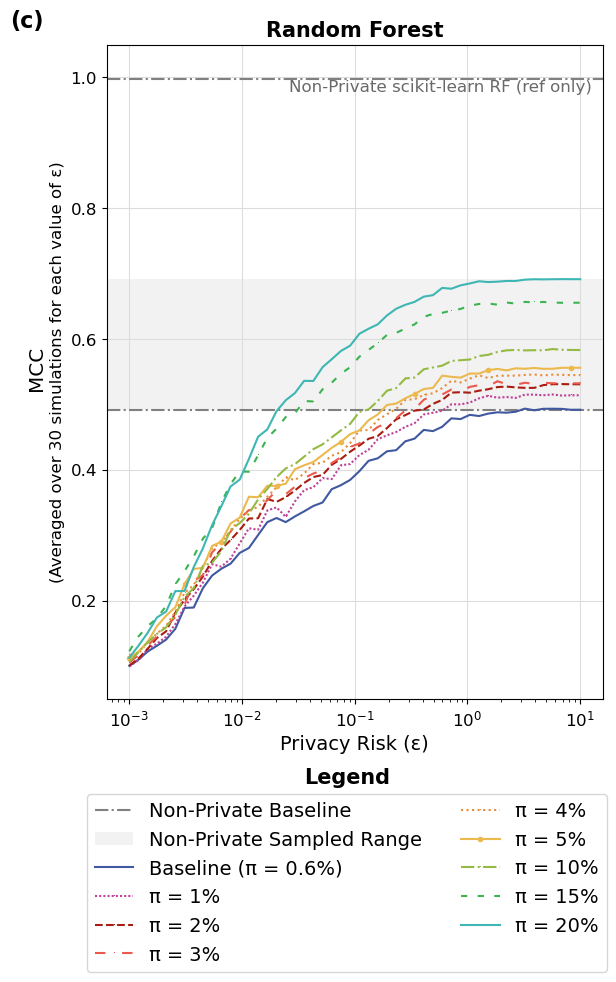

In [98]:
# Plot the tall version of the second graph

# Create the figure with the specified size
fig_rf2 = plt.figure(figsize=(6.4, 8.5))  # Reduced height for the plot area

# Plot the non-DP sampled values
# Use list comprehension to plot multiple horizontal lines
[plt.axhline(y=y, color=color, linestyle=style, label=label) for y, color, style, label in zip(
    [rf_noDP_mcc_list.mean(), rf_DP_mcc_list.mean()],
    ['grey', 'grey'],
    ['-.', '-.'],
    ["", "Non-Private Baseline"])
]

# Add range of non-DP sampled values
rf_MCC_min = min(avg_rf_noDP_sampled_mcc_dict.values())
rf_MCC_max = max(avg_rf_noDP_sampled_mcc_dict.values())
plt.axhspan(rf_MCC_max, rf_MCC_min, facecolor='silver', alpha=0.2, label="Non-Private Sampled Range")

# Plot the results from plot 1
plt.semilogx(epsilons[:-1], avg_DPrf_sampled_mcc_dict['Baseline'], color='#40589F', label="Baseline (π = 0.6%)", marker=',', markevery=.1)

# Add the sampled lines for comparison
colors = ['#BE4196', '#A91C11', '#EB594D', '#E88C38', '#EBB94D', '#94BA42', '#3BB450', '#3EB6B4']
labels = ['π = 1%', 'π = 2%', 'π = 3%', 'π = 4%', 'π = 5%', 'π = 10%', 'π = 15%', 'π = 20%']
widths = [1.5, 1.5, 1.5, 1.5, 1.5, 1.5, 1.5, 1.5 ]
styles = [(0, (1, 1)), '--', (0, (5, 8)), ':', '-', '-.', (0, (3, 5)), '-' ]
markers= [",", ",", ",", ",", ".", ",", ",", ","] 

for name, color, label, width, style, marker in zip(colNames[:], colors, labels, widths, styles, markers):
    plt.semilogx(epsilons[:-1], avg_DPrf_sampled_mcc_dict[name], color=color, label=label, linewidth=width, linestyle=style, marker=marker, markevery=.1)

plt.title("Random Forest", fontweight='bold', fontsize=15)
plt.grid(which='major', color='#DDDDDD', linewidth=0.8)
plt.xlabel("Privacy Risk (ε)", fontsize=14)
plt.ylabel("(Averaged over 30 simulations for each value of ε)", fontsize=12)
fig_rf2.figure.supylabel("MCC", fontsize="x-large", x=0)

# Set y-axis limits
plt.ylim(0.05, 1.05)  # Set limits to prevent stretching

# Set font size for tick labels
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

# Add the legend below the plot
handles, labels = plt.gca().get_legend_handles_labels()
legend = fig_rf2.legend(handles, labels, loc='upper center', ncol=2, bbox_to_anchor=(0.5, .01), fontsize=14)

# Add a separate text elements
plt.figtext(0.5, .01, "Legend", ha="center", fontsize=plt.gca().title.get_fontsize(), fontweight='bold')
plt.figtext(0, 0.9, "(c)", ha="center", fontsize=16, fontweight='bold')
plt.figtext(0.41, 0.825, 'Non-Private scikit-learn RF (ref only)', horizontalalignment='left', wrap=True, color='dimgray', fontsize=12)

# Save and show the plot
plt.savefig('../figures/RF-Graph5.png', dpi=600, bbox_inches='tight')
plt.show()

In [70]:
print(rf_MCC_min)
print(rf_MCC_max)

0.49216114940283195
0.6916047398544374


In [66]:
# Calculate Runtimes
rf_runtime.loc['Runtime'] = rf_runtime.loc['End Time'] - rf_runtime.loc['Start Time']

# Output Runtime data
rf_runtime

,Setup,Validate,Baseline,Compare
Start Time,1730766181.113017,1730766182.119867,1730766975.841961,1730771394.724388
End Time,1730766182.11531,1730766975.839215,1730771393.634797,1730813808.592844
Runtime,1.002293,793.719348,4417.792836,42413.868456


In [78]:
print(avg_DPrf_sampled_mcc_dict['20%'])

epsilon
0.001000     0.113348
0.001207     0.131611
0.001456     0.151387
0.001758     0.174664
0.002121     0.183789
0.002560     0.214966
0.003089     0.215194
0.003728     0.251654
0.004498     0.280434
0.005429     0.315879
0.006551     0.344612
0.007906     0.374777
0.009541     0.385403
0.011514     0.416941
0.013895     0.450911
0.016768     0.462095
0.020236     0.489958
0.024421     0.506642
0.029471     0.517637
0.035565     0.536271
0.042919     0.536077
0.051795     0.557083
0.062506     0.569346
0.075431     0.581941
0.091030     0.590011
0.109854     0.608148
0.132571     0.615869
0.159986     0.622585
0.193070     0.636132
0.232995     0.646424
0.281177     0.652474
0.339322     0.656906
0.409492     0.664920
0.494171     0.667216
0.596362     0.678249
0.719686     0.677054
0.868511     0.682170
1.048113     0.685060
1.264855     0.688406
1.526418     0.687242
1.842070     0.687795
2.222996     0.688903
2.682696     0.688889
3.237458     0.690883
3.906940     0.691507
4.

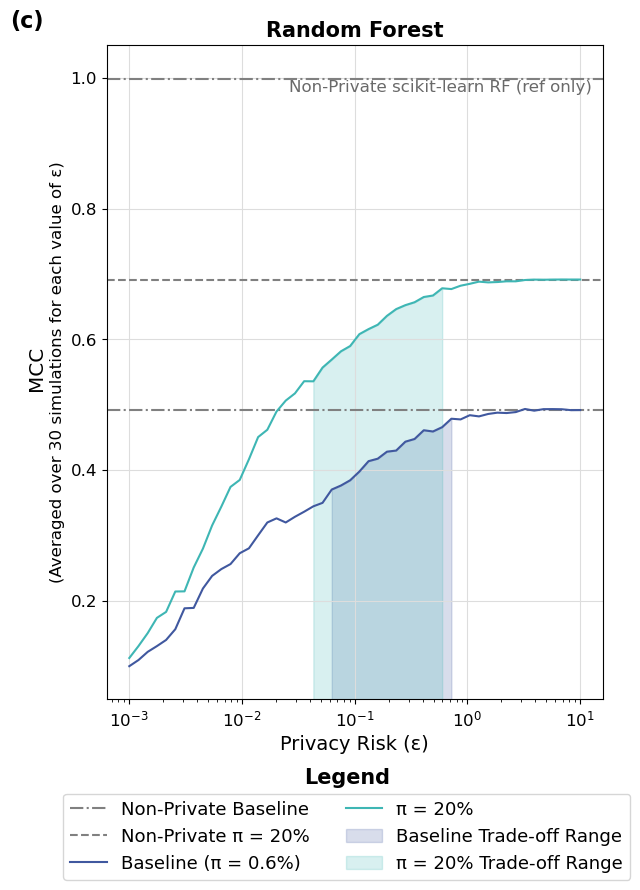

In [100]:
# Baseline to 20% imbalance comparison

# Create the figure with the specified size
fig_rf3 = plt.figure(figsize=(6.4, 8.5)) 

# Use list comprehension to plot multiple horizontal lines
[plt.axhline(y=y, color=color, linestyle=style, label=label) for y, color, style, label in zip(
    [rf_noDP_mcc_list.mean(), rf_DP_mcc_list.mean(), avg_rf_noDP_sampled_mcc_dict['20%']],
    ['grey', 'grey', 'grey'],
    ['-.', '-.', '--'],
    ["", "Non-Private Baseline", "Non-Private π = 20%"])
]

# Plot the results
plt.semilogx(epsilons[:-1], avg_DPrf_mcc, color='#40589F', label="Baseline (π = 0.6%)") # :-1 when infinity is included
plt.semilogx(epsilons[:-1], avg_DPrf_sampled_mcc_dict['20%'], color='#3EB6B4', label="π = 20%")

# Define the bounds for x values
x_lower_rfb, x_upper_rfb = 0.051795, 0.719686
x_lower_lr20, x_upper_lr20 = 0.035565, 0.6

# Find the indices where epsilons fall within the specified x range
x_mask_rfb = (epsilons[:-1] >= x_lower_rfb) & (epsilons[:-1] <= x_upper_rfb)
x_mask_lr20 = (epsilons[:-1] >= x_lower_lr20) & (epsilons[:-1] <= x_upper_lr20)

# Fill the area under the curve between 0 and the curve values
plt.fill_between(epsilons[:-1][x_mask_rfb], 0, avg_DPrf_mcc[x_mask_rfb], 
                 where=(avg_DPrf_mcc[x_mask_rfb] >= 0), 
                 color='#40589F', alpha=0.2, label="Baseline Trade-off Range")

plt.fill_between(epsilons[:-1][x_mask_lr20], 0, avg_DPrf_sampled_mcc_dict['20%'][x_mask_lr20], 
                 where=(avg_DPrf_sampled_mcc_dict['20%'][x_mask_lr20] >= 0), 
                 color='#3eb6B4', alpha=0.2, label="π = 20% Trade-off Range")


plt.title("Random Forest", fontweight='bold', fontsize=15)
plt.grid(which='major', color='#DDDDDD', linewidth=0.8)
plt.xlabel("Privacy Risk (ε)", fontsize=14)
plt.ylabel("(Averaged over 30 simulations for each value of ε)", fontsize=12)
fig_rf3.figure.supylabel("MCC", fontsize="x-large", x=0)

# Set y-axis limits
plt.ylim(0.05, 1.05)  # Set limits to prevent stretching

# Set font size for tick labels
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

# Add the legend below the plot
handles, labels = plt.gca().get_legend_handles_labels()
legend = fig_rf3.legend(handles, labels, loc='upper center', ncol=2, bbox_to_anchor=(0.5, .01), fontsize=13)

# Add a separate text elements
plt.figtext(0.5, 0.01, "Legend", ha="center", fontsize=plt.gca().title.get_fontsize(), fontweight='bold')
plt.figtext(0, 0.9, "(c)", ha="center", fontsize=16, fontweight='bold')
plt.figtext(0.41, 0.825, 'Non-Private scikit-learn RF (ref only)', horizontalalignment='left', wrap=True, color='dimgray', fontsize=12)

# Save and show the plot
plt.savefig('../figures/RF-Graph6.png', dpi=600, bbox_inches='tight') 
plt.show()